# =============================================================
# MILESTONE 2: Advanced Data Analysis and Feature Engineering
# =============================================================

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [18]:
# Set plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [19]:
url = "https://raw.githubusercontent.com/Reemsoliiman/customer-churn-prediction-analysis/main/data/processed/cleaned_data.csv"
df = pd.read_csv(url)

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")


Dataset loaded: 2666 rows, 77 columns


# ========================
# 1. Advanced Data Analysis
# ========================

# -------------------------------------
# 1.1 statistical tests
# -------------------------------------

In [20]:
# T-test for Customer service calls
group1 = df[df['Churn'] == False]['Customer service calls']
group2 = df[df['Churn'] == True]['Customer service calls']
t_stat, p_value = stats.ttest_ind(group1, group2)
print(f"T-test for Customer service calls: t={t_stat:.3f}, p={p_value:.3f}")

T-test for Customer service calls: t=-10.678, p=0.000


In [21]:
# T-test for Total day minutes
group1 = df[df['Churn'] == False]['Total day minutes']
group2 = df[df['Churn'] == True]['Total day minutes']
t_stat, p_value = stats.ttest_ind(group1, group2)
print(f"T-test for Total day minutes: t={t_stat:.3f}, p={p_value:.3f}")

T-test for Total day minutes: t=-10.278, p=0.000


In [22]:
categorical_cols = [
    'State_AL', 'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL', 'State_GA',
    'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD',
    'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH',
    'State_NJ', 'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI', 'State_SC',
    'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY',
    'Area code_415', 'Area code_510', 'International plan_Yes', 'Voice mail plan_Yes',
    'Account_Length_Binned_Medium', 'Account_Length_Binned_Long'
]

In [23]:
# Perform Chi-squared tests
chi2_results = []

for col in categorical_cols:
    if col != "Churn":  # Exclude Churn as it's the target
        contingency_table = pd.crosstab(df[col], df["Churn"])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        chi2_results.append({"Feature": col, "Chi2": chi2, "p-value": p})

# Convert to DataFrame and sort by p-value
chi2_df = pd.DataFrame(chi2_results).sort_values("p-value")

# Display results
print("Chi-squared Test Results:")
display(chi2_df)

# Highlight significant features (p < 0.05)
significant_features = chi2_df[chi2_df['p-value'] < 0.05]
print("\nSignificant Features (p < 0.05):")
display(significant_features)

Chi-squared Test Results:


,Feature,Chi2,p-value
52,International plan_Yes,202.682107,5.426941e-46
53,Voice mail plan_Yes,25.656253,4.079713e-07
42,State_TX,8.387384,3.778344e-03
30,State_NJ,6.347637,1.175378e-02
44,State_VA,3.394592,6.541052e-02
19,State_MD,3.116797,7.748898e-02
10,State_HI,2.831656,9.242303e-02
48,State_WV,2.661709,1.027902e-01
47,State_WI,2.585552,1.078428e-01
21,State_MI,2.334930,1.265007e-01



Significant Features (p < 0.05):


,Feature,Chi2,p-value
52,International plan_Yes,202.682107,5.426941e-46
53,Voice mail plan_Yes,25.656253,4.079713e-07
42,State_TX,8.387384,3.778344e-03
30,State_NJ,6.347637,1.175378e-02


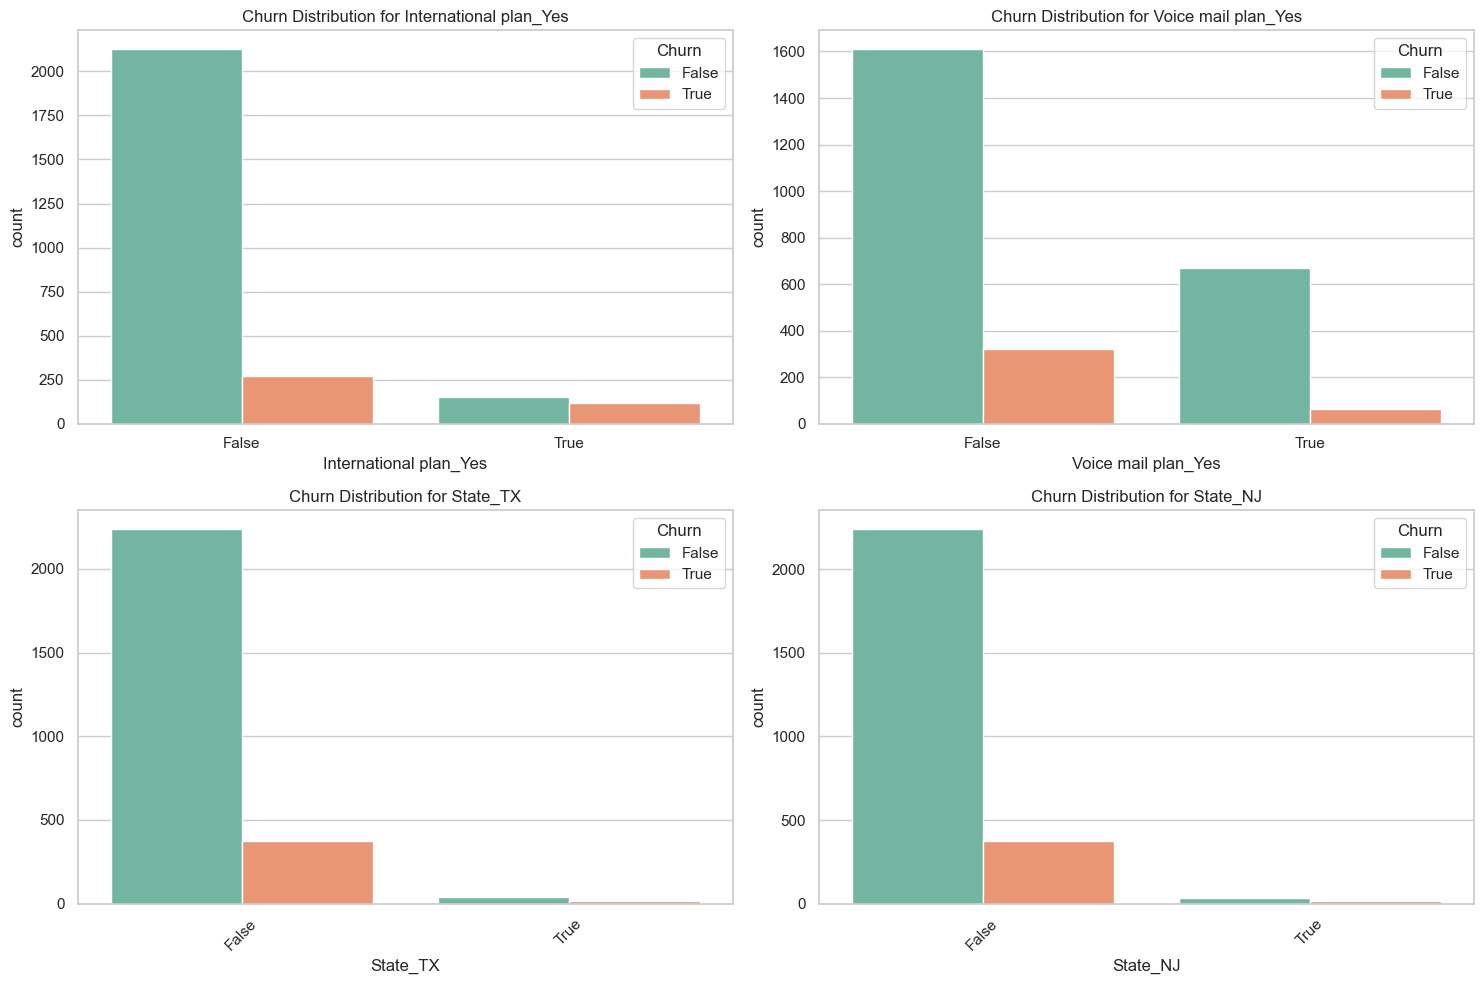

In [24]:
# Visualize significant features with countplot
plt.figure(figsize=(15, 10))
n_cols = 2
n_rows = int(np.ceil(len(significant_features) / n_cols))

for i, row in enumerate(significant_features.itertuples(), 1):
    col = row.Feature
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=df, x=col, hue='Churn', palette='Set2')
    plt.title(f'Churn Distribution for {col}')
    plt.xticks(rotation=45 if 'State' in col else 0)  # Rotate x-labels for State columns
    plt.legend(title='Churn', labels=['False', 'True'])

plt.tight_layout()
plt.show()

In [25]:
for i, row in chi2_df.iterrows():
    signif = "Significant" if row["p-value"] < 0.05 else "Not Significant"
    print(f"{row['Feature']}: p-value={row['p-value']:.4f} --> {signif}")

International plan_Yes: p-value=0.0000 --> Significant
Voice mail plan_Yes: p-value=0.0000 --> Significant
State_TX: p-value=0.0038 --> Significant
State_NJ: p-value=0.0118 --> Significant
State_VA: p-value=0.0654 --> Not Significant
State_MD: p-value=0.0775 --> Not Significant
State_HI: p-value=0.0924 --> Not Significant
State_WV: p-value=0.1028 --> Not Significant
State_WI: p-value=0.1078 --> Not Significant
State_MI: p-value=0.1265 --> Not Significant
State_AR: p-value=0.1267 --> Not Significant
State_MS: p-value=0.1466 --> Not Significant
State_RI: p-value=0.1499 --> Not Significant
State_SC: p-value=0.1684 --> Not Significant
State_ME: p-value=0.1684 --> Not Significant
State_NV: p-value=0.1834 --> Not Significant
State_AZ: p-value=0.1936 --> Not Significant
State_PA: p-value=0.2820 --> Not Significant
State_WA: p-value=0.2990 --> Not Significant
State_ID: p-value=0.3101 --> Not Significant
State_NH: p-value=0.3284 --> Not Significant
State_IA: p-value=0.3468 --> Not Significant
S

# -------------------------------------
# 1.2 identifying most relevant features
# -------------------------------------

In [26]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop('Churn').tolist()
print("Numerical columns:", numeric_cols)

Numerical columns: ['Account length', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls', 'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost', 'Total_Calls', 'High_Customer_Service']


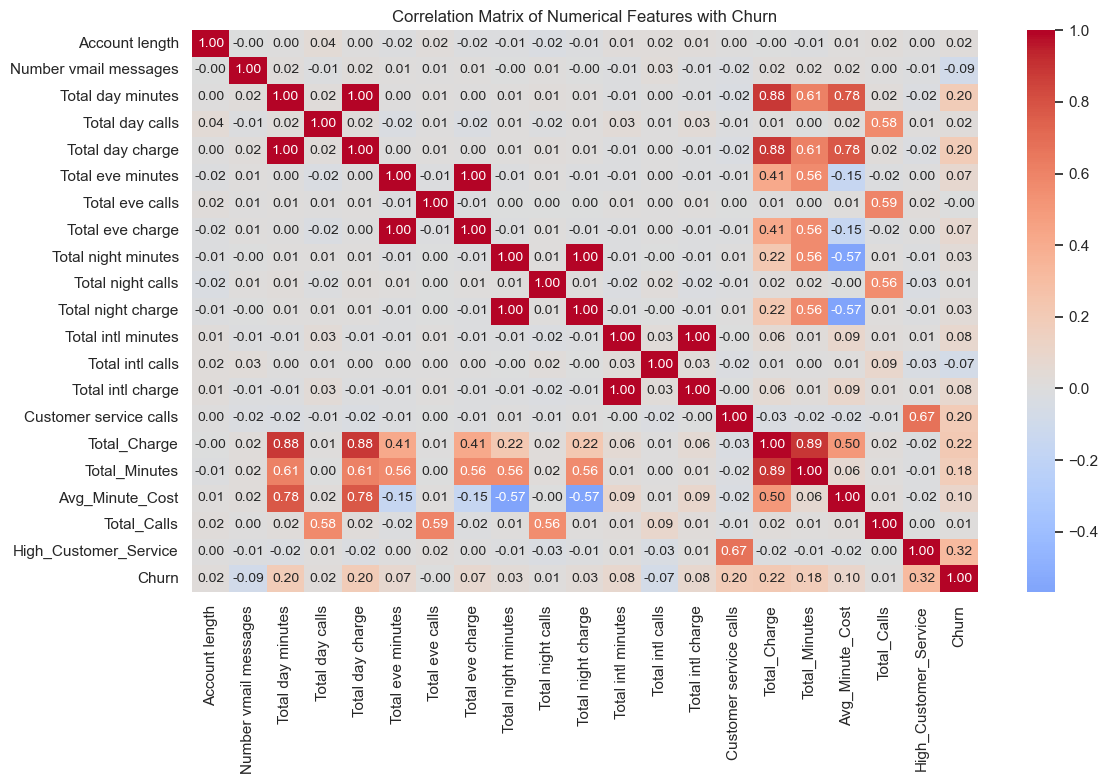

Correlations with Churn:
 Churn                     1.000000
High_Customer_Service     0.317615
Total_Charge              0.215042
Customer service calls    0.202590
Total day minutes         0.195305
Total day charge          0.195300
Total_Minutes             0.180062
Avg_Minute_Cost           0.096299
Total intl minutes        0.084710
Total intl charge         0.084706
Total eve minutes         0.072085
Total eve charge          0.072067
Total night minutes       0.034318
Total night charge        0.034317
Total day calls           0.018290
Account length            0.017332
Total night calls         0.012262
Total_Calls               0.011650
Total eve calls          -0.001539
Total intl calls         -0.069882
Number vmail messages    -0.086474
Name: Churn, dtype: float64


In [27]:
correlation_matrix = df[numeric_cols + ['Churn']].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Numerical Features with Churn')
plt.tight_layout()
plt.show()

# Display correlations with Churn
churn_correlations = correlation_matrix['Churn'].sort_values(ascending=False)
print("Correlations with Churn:\n", churn_correlations)

Feature Ranking from RFE:
                    Feature  Ranking  Selected
7         Total eve charge        1      True
15            Total_Charge        1      True
10      Total night charge        1      True
8      Total night minutes        1      True
17         Avg_Minute_Cost        1      True
19   High_Customer_Service        2     False
4         Total day charge        3     False
2        Total day minutes        4     False
11      Total intl minutes        5     False
1    Number vmail messages        6     False
5        Total eve minutes        7     False
13       Total intl charge        8     False
12        Total intl calls        9     False
9        Total night calls       10     False
0           Account length       11     False
16           Total_Minutes       12     False
6          Total eve calls       13     False
3          Total day calls       14     False
14  Customer service calls       15     False
18             Total_Calls       16     False


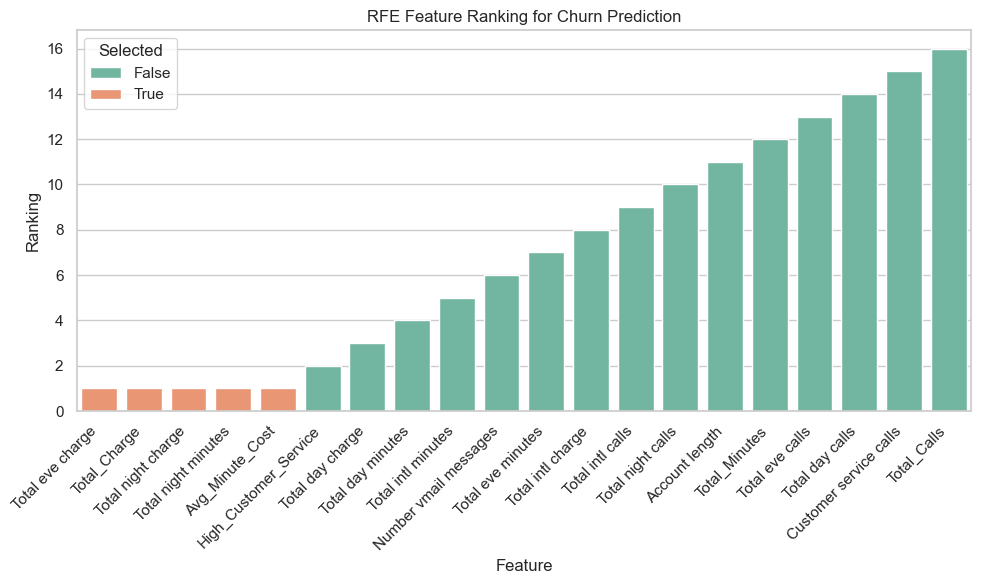

In [28]:
# Prepare data for RFE
X = df[numeric_cols]
y = df['Churn']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Apply RFE
rfe = RFE(estimator=model, n_features_to_select=5)  # Select top 5 features
rfe = rfe.fit(X_scaled, y)

# Get results
feature_ranking = pd.DataFrame({
    'Feature': numeric_cols,
    'Ranking': rfe.ranking_,
    'Selected': rfe.support_
})
feature_ranking = feature_ranking.sort_values('Ranking')

# Display results
print("Feature Ranking from RFE:\n", feature_ranking)

# Plot feature importance (based on selection)
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_ranking, x='Feature', y='Ranking', hue='Selected', palette='Set2', dodge=False)
plt.xticks(rotation=45, ha='right')
plt.title('RFE Feature Ranking for Churn Prediction')
plt.tight_layout()
plt.show()

# ========================
# 2. Feature Engineering
# ========================

# -------------------------------------
# 2.1 Create New Features
# -------------------------------------

In [29]:
#Rename column
df['Customer tenure'] = df['Account length']

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 78 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Account length                2666 non-null   int64  
 1   Number vmail messages         2666 non-null   int64  
 2   Total day minutes             2666 non-null   float64
 3   Total day calls               2666 non-null   int64  
 4   Total day charge              2666 non-null   float64
 5   Total eve minutes             2666 non-null   float64
 6   Total eve calls               2666 non-null   int64  
 7   Total eve charge              2666 non-null   float64
 8   Total night minutes           2666 non-null   float64
 9   Total night calls             2666 non-null   int64  
 10  Total night charge            2666 non-null   float64
 11  Total intl minutes            2666 non-null   float64
 12  Total intl calls              2666 non-null   int64  
 13  Tot

# -------------------------------------
# 2.1.1 Usage Patterns
# -------------------------------------

In [31]:
#Average daily usage
df['average daily usage'] = df['Total_Minutes'] / df['Customer tenure']

In [32]:
#Average calls per day
df['Average calls per day'] = (
df['Total_Calls']/df['Customer tenure']
)

In [33]:
#Average minutes per call
df['Average minutes per call'] = np.where(
    df['Total_Calls'] > 0,
    df['Total_Minutes'] / df['Total_Calls'],
    0
)

# -------------------------------------
# 2.1.2 Frequency Of Interactions
# -------------------------------------

In [34]:
#Complaint indicator
df['High service calls'] = (df['Customer service calls'] > 3).astype(int)

In [35]:
#Interaction frequency index
df['Calls per tenure'] = df['Total_Calls'] / df['Customer tenure']

# -------------------------------------
# 2.2 FEATURE TRANSFORMATION
# -------------------------------------

In [36]:
#Log transform highly skewed features
for col in ['Total_Minutes', 'average daily usage', 'Average minutes per call']:
    df[f'log_{col.replace(" ", "_").lower()}'] = np.log1p(df[col])  # log1p handles zeros safely

# -------------------------------------
# 2.3 FEATURE SCALING
# -------------------------------------

In [37]:
scaler = MinMaxScaler()
numeric_features = [
    'Customer tenure',
    'Total_Minutes',
    'average daily usage',
    'Total_Calls',
    'Average calls per day',
    'Average minutes per call',
    'Calls per tenure'
]
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

# -------------------------------------
# 2.4 ENCODING CATEGORICAL VARIABLES
# -------------------------------------

In [38]:
#One-hot encode binary categorical variables(already encoded in milestone 1)
df_encoded =df_scaled

In [39]:
print(df_scaled.columns)

Index(['Account length', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn', 'Total_Charge', 'Total_Minutes', 'Avg_Minute_Cost',
       'Total_Calls', 'High_Customer_Service', 'State_AL', 'State_AR',
       'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE',
       'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL',
       'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD',
       'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT',
       'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM',
       'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA',
       'State_RI', 'State_SC', 'St

In [40]:
print("Final feature set shape:", df_encoded.shape)
df_encoded.head()

Final feature set shape: (2666, 86)


,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,...,Account_Length_Binned_Long,Customer tenure,average daily usage,Average calls per day,Average minutes per call,High service calls,Calls per tenure,log_total_minutes,log_average_daily_usage,log_average_minutes_per_call
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,...,True,0.613527,0.005248,0.002942,0.575932,0,0.002942,6.576748,1.887543,1.214021
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,...,False,0.512077,0.005586,0.004879,0.398252,0,0.004879,6.439670,1.923225,1.058877
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,...,True,0.657005,0.002899,0.003109,0.301561,0,0.003109,6.292310,1.596804,0.963106
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,...,False,0.400966,0.006828,0.004702,0.520081,0,0.004702,6.338241,2.044308,1.167797
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,...,False,0.357488,0.006973,0.009313,0.230456,0,0.009313,6.240276,2.057537,0.886320
